In [1]:
import torch
import numpy as np
import pytorch_lightning as pl
import torchvision.transforms as tf
from tqdm import tqdm
from predict import *
from HGGEP import *
from dataset import ViT_HER2ST, ViT_SKIN
from scipy.stats import pearsonr,spearmanr
from torch.utils.data import DataLoader
from pytorch_lightning.loggers import TensorBoardLogger
from copy import deepcopy as dcp
from collections import defaultdict as dfd
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi_score

/home/zy/anaconda3/envs/gtn/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/zy/anaconda3/envs/gtn/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[easydl] tensorflow not available!


# Data Loading

In [2]:
name=[*[f'A{i}' for i in range(2,7)],*[f'B{i}' for i in range(1,7)],
      *[f'C{i}' for i in range(1,7)],*[f'D{i}' for i in range(1,7)],
      *[f'E{i}' for i in range(1,4)],*[f'F{i}' for i in range(1,4)],*[f'G{i}' for i in range(1,4)]]
patients = ['P2', 'P5', 'P9', 'P10']
reps = ['rep1', 'rep2', 'rep3']
skinname = []
for i in patients:
    for j in reps:
        skinname.append(i+'_ST_'+j)
device='cuda'
tag='5-7-2-8-4-16-32'
k,p,d1,d2,d3,h,c=map(lambda x:int(x),tag.split('-'))
dropout=0.2
random.seed(12000)
np.random.seed(12000)
torch.manual_seed(12000)
torch.cuda.manual_seed(12000)
torch.cuda.manual_seed_all(12000)  
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True


# Hist2ST Prediction

### To run the trained model, please select the trained model and replace the value of the variable fold with the number in the name of the selected trained model.

Test one!

In [4]:
fold=12
data='her2st'
prune='Grid' if data=='her2st' else 'NA'
genes=171 if data=='cscc' else 785

testset = pk_load(fold,'test',dataset=data,flatten=False,adj=True,ori=True,prune=prune)
test_loader = DataLoader(testset, batch_size=1, num_workers=0, shuffle=False)
label=testset.label[testset.names[0]]
genes=785
model=HGGEP(
    depth1=d1, depth2=d2,depth3=d3,n_genes=genes, 
    kernel_size=k, patch_size=p,
    heads=h, channel=c, dropout=0.2,
    zinb=0.25, nb=False,
    bake=5, lamb=0.5, 
)

te_names: ['C2']
Loading imgs...
Loading metadata...


In [ ]:
# Test all

folds=[]
for i in range(32):
    folds.append(i)
print(folds)
data='her2st'
prune='Grid' if data=='her2st' else 'NA'
genes=171 if data=='cscc' else 785

R_HGGEP = []

for fold in folds:
    testset = pk_load(fold,'test',dataset=data,flatten=False,adj=True,ori=True,prune=prune)
    test_loader = DataLoader(testset, batch_size=1, num_workers=0, shuffle=False)
    label=testset.label[testset.names[0]]
    # genes=785
    model=HGGEP(
        depth1=d1, depth2=d2,depth3=d3,n_genes=genes, 
        kernel_size=k, patch_size=p,
        heads=h, channel=c, dropout=0.2,
        zinb=0.25, nb=False,
        bake=0, lamb=0.5,
    )
    model.load_state_dict(torch.load(f'./model/her2st/'+str(fold)+'-HGGEP.ckpt'))
    pred, gt = test(model, test_loader,'cuda')
    R=get_R(pred,gt)[0]
    R_HGGEP.append(R)
    print('Pearson Correlation Median:',np.nanmedian(R))

In [21]:
# add mean and median

import numpy as np

# print(len(R_HGGEP))
# print(len(R_Hist2ST))

# # add mean and median
# mean_HGGEP = np.mean(R_STNet, axis=0)
# # mean_Hist2ST = np.mean(R_Hist2ST, axis=0)

# median_HGGEP = np.median(R_STNet, axis=0)
# # median_Hist2ST = np.median(R_Hist2ST, axis=0)

# R_HGGEP_with_mean_median = np.vstack([R_STNet, mean_HGGEP, median_HGGEP])
# # R_Hist2ST_with_mean_median = np.vstack([R_Hist2ST, mean_Hist2ST, median_Hist2ST])


# # print(R_HGGEP_with_mean_median.shape)
# # print(R_Hist2ST_with_mean_median.shape)
# print(R_HGGEP_with_mean_median.shape, R_HGGEP_with_mean_median[-1][:10]) 

# np.save('./Output/STNet_her2.npy', R_HGGEP_with_mean_median)
# np.save('Hist2ST_output.npy', R_Hist2ST_with_mean_median)

R_HGGEP_with_mean_median = np.load('./Output/HGGEP_her2.npy')
R_Hist2ST_with_mean_median = np.load('./Output/Hist2ST_her2.npy')
R_HisToGene_with_mean_median = np.load('./Output/HisToGene_her2.npy')
R_STNet_with_mean_median = np.load('./Output/STNet_her2.npy')


In [8]:
print(R_HGGEP_with_mean_median.shape) 
print(R_Hist2ST_with_mean_median.shape)
print(R_HisToGene_with_mean_median.shape)
print(R_HisToGene_with_mean_median.shape)

# Extract the last subarrays
last_subarray_HGGEP = R_HGGEP_with_mean_median[-2, :]
last_subarray_Hist2ST = R_Hist2ST_with_mean_median[-2, :]
# Convert to Pandas DataFrame
df_last_HGGEP = pd.DataFrame(last_subarray_HGGEP)
df_last_Hist2ST = pd.DataFrame(last_subarray_Hist2ST)

# Calculate mean and median using Pandas DataFrame methods
mean_HGGEP = df_last_HGGEP.mean().values
mean_Hist2ST = df_last_Hist2ST.mean().values

median_HGGEP = np.median(R_HGGEP_with_mean_median[:, -1])
median_Hist2ST = np.median(R_Hist2ST_with_mean_median[:, -1])


# Print the results
print("Mean HGGEP:", mean_HGGEP)
print("Mean Hist2ST:", mean_Hist2ST)
print("Median HGGEP:", median_HGGEP)
print("Median Hist2ST:", median_Hist2ST)

(34, 785)
(34, 785)
(34, 785)
(34, 785)
Mean HGGEP: [0.19456845]
Mean Hist2ST: [0.15636345]
Median HGGEP: 0.11109329471896254
Median Hist2ST: 0.0950236368053993


# Figure 2, comprasion of different models

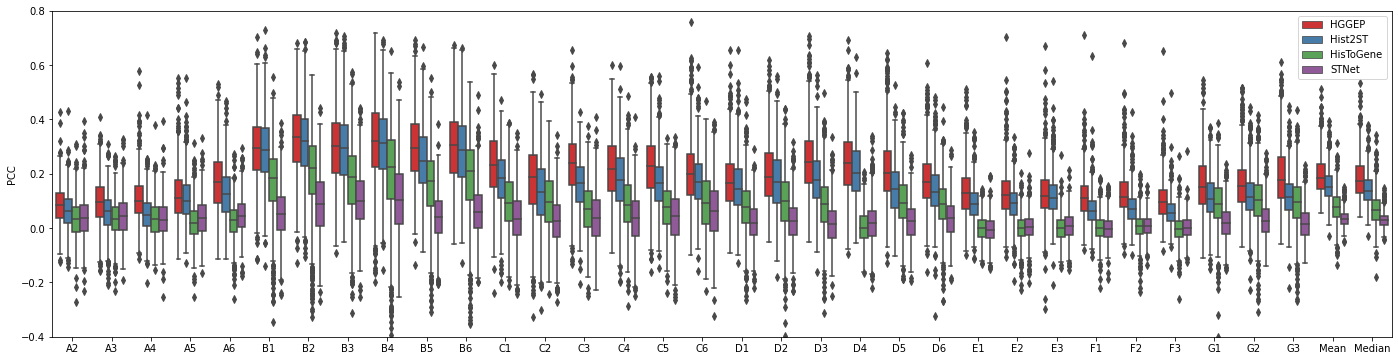

In [22]:
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

R_HGGEP_with_mean_median = np.load('./Output/HGGEP_her2.npy')
R_Hist2ST_with_mean_median = np.load('./Output/Hist2ST_her2.npy')
R_HisToGene_with_mean_median = np.load('./Output/HisToGene_her2.npy')
R_STNet_with_mean_median = np.load('./Output/STNet_her2.npy')


x_label = ['A2', 'A3', 'A4', 'A5', 'A6', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'C1', 'C2', 'C3', \
           'C4', 'C5', 'C6', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'E1', 'E2', 'E3', 'F1', 'F2', 'F3', 'G1', 'G2', 'G3', 'Mean', 'Median']

df_combined = pd.DataFrame()

for i in range(34):
    df_class_i = pd.DataFrame(np.transpose(np.array([R_HGGEP_with_mean_median[i], R_Hist2ST_with_mean_median[i],\
                                                      R_HisToGene_with_mean_median[i], R_STNet_with_mean_median[i]])),\
                                                      columns=['HGGEP', 'Hist2ST', 'HisToGene', 'STNet'])
    # df_class_i = pd.DataFrame(data_class1, columns=['HGGEP', 'Hist2ST', 'HisToGene'])
    df_class_i['Category'] = x_label[i]

    df_combined = df_combined._append(df_class_i, ignore_index=True)

df_combined_melted = pd.melt(df_combined, id_vars=['Category'], var_name='Column')

plt.figure(figsize=(24, 6))  # width and high

# sns.boxplot(x='Category', y='value', data=df_combined_melted, hue='Column', showfliers=True, width=0.8, palette='Set2')
boxplot = sns.boxplot(x='Category', y='value', data=df_combined_melted, hue='Column', showfliers=True, width=0.8, palette='Set1')

plt.ylim(-0.4, 0.8)

plt.gcf().set_facecolor('white')

plt.legend(title='')

# plt.title('Boxplots of Columns by Category')
plt.xlabel('')
plt.ylabel('PCC')

# plt.show()
plt.savefig('./figures/2_HER2+.pdf')
# plt.savefig('./figures/HER2+.png', dpi=600)

# Test her2st all!

In [ ]:
folds=[]
from HGGEP import *
for i in range(32):
    folds.append(i)

data='her2st'
prune='Grid' if data=='her2st' else 'NA'
genes=171 if data=='cscc' else 785
gene_names = list(np.load('data/her_hvg_cut_1000.npy',allow_pickle=True))

def comp_tsne_km(adata,k=10):
    sc.pp.pca(adata)
    sc.tl.tsne(adata)
    kmeans = KMeans(n_clusters=k, init="k-means++", random_state=0).fit(adata.obsm['X_pca'])
    adata.obs['kmeans'] = kmeans.labels_.astype(str)
    return adata

def get_PCC(adata_pre, adata_true):
    gene_names = adata_pre.columns
    result_df = pd.DataFrame(index=['-log10_PV', 'PCC', 'PV',], columns=gene_names)
    for gene in gene_names:
        corr_coef, p_value = pearsonr(adata_pre[gene], adata_true[gene])
        result_df[gene] = [-np.log10(p_value), corr_coef, p_value]
    result_df = result_df.T
    result_df_sorted = result_df.sort_values(by='-log10_PV', ascending=False)

    return result_df_sorted

results_all = []
for fold in folds:
    testset = pk_load(fold,'test',dataset=data,flatten=False,adj=True,ori=True,prune=prune)
    test_loader = DataLoader(testset, batch_size=1, num_workers=0, shuffle=False)
    label=testset.label[testset.names[0]]
    model=Hist2ST(
        depth1=d1, depth2=d2,depth3=d3,n_genes=genes, 
        kernel_size=k, patch_size=p,
        heads=h, channel=c, dropout=0.2,
        zinb=0.25, nb=False,
        bake=5, lamb=0.5,
    )
    model.load_state_dict(torch.load(f'/media/zy/MyPassport/UF/her2st/'+str(fold)+'-HGGEP.ckpt'))
    # model.load_state_dict(torch.load(f'./model/Hist2ST_Best_0.3031.ckpt'))
    adata_pred, adata_truth = test(model, test_loader)

    adata_pred = comp_tsne_km(adata_pred,4)
    sc.pp.scale(adata_pred)
    sc.pp.scale(adata_truth)
    adata_pred.var_names = gene_names
    adata_truth.var_names = gene_names
    adata_true = pd.DataFrame(data=adata_truth.X, index=adata_truth.obs_names, columns=adata_truth.var_names)
    adata_pre = pd.DataFrame(data=adata_pred.X, index=adata_pred.obs_names, columns=adata_pred.var_names)
    res = get_PCC(adata_pre, adata_true)
    # print(res)
    results_all.append(res)


# Top gene prediction

In [ ]:
# Calculate the mean across all DataFrames element-wise
mean_df = np.mean([df.values for df in results_all], axis=0)

# Create a new DataFrame with the mean values
mean_df = pd.DataFrame(mean_df, index=results_all[0].index, columns=results_all[0].columns)

# Print the resulting DataFrame
print(mean_df[:10])

# HGGEP
#          -log10_PV       PCC            PV
# GNAS     41.461921  0.623105  5.491569e-17
# UBA52    30.599432  0.565826  9.797935e-13
# MUCL1    27.730870  0.542192  1.220741e-10
# HLA-B    25.330913  0.522077  7.795413e-09
# HLA-DRA  24.376753  0.513529  1.439333e-08
# SRSF5    22.948412  0.500819  3.473500e-08
# VIM      21.857428  0.491059  9.101760e-08
# CXXC5    21.167107  0.483817  9.344792e-08
# SPARC    20.375119  0.475803  9.928255e-08
# FASN     19.608907  0.467966  1.183600e-07

In [ ]:
# Hist2ST
# Calculate the mean across all DataFrames element-wise
mean_df = np.mean([df.values for df in Hist2ST_results_all], axis=0)

# Create a new DataFrame with the mean values
mean_df = pd.DataFrame(mean_df, index=Hist2ST_results_all[0].index, columns=Hist2ST_results_all[0].columns)
print(mean_df[:10])
# Print the resulting DataFrame
for gene in ['GNAS', 'UBA52', 'MUCL1', 'HLA-B', 'HLA-DRA', 'SRSF5', 'VIM', 'CXXC5', 'SPARC', 'FASN']:
    print(mean_df.loc[gene])

#           -log10_PV       PCC            PV
# IGKC      27.371680  0.528938  1.432967e-10
# C3        20.338023  0.468656  6.180550e-08
# GNAS      18.061492  0.444435  7.871247e-08
# KRT17     17.083069  0.433135  3.483668e-07
# IGLC2     16.144405  0.422656  4.038377e-07
# IGLC3     15.592970  0.415894  5.110269e-07
# TMEM184A  14.760000  0.404774  1.010671e-06
# TFF3      14.316007  0.398951  1.253905e-06
# SCD       13.835811  0.392418  2.050736e-06
# MYL12B    13.382646  0.385515  3.082886e-06

In [ ]:
# HisToGene
#          -log10_PV       PCC        PV
# GNAS     13.793088  0.323096  0.000024
# SCD      11.294036  0.283800  0.000046
# IGLC2    10.137152  0.294930  0.000093
# C3        9.618945  0.294796  0.000134
# FASN      9.240102  0.257429  0.000224
# MYL12B    8.911048  0.293260  0.000297
# APOC1     8.569591  0.230732  0.000356
# TMEM123   8.179363  0.251036  0.000419
# SRRT      7.899371  0.247817  0.000480
# IGHA1     7.708450  0.266133  0.000530


# Figure 5. Spatial domain detection based on predicted gene expressions. 

In [ ]:
import matplotlib.pyplot as plt

# decide which model for generating adata_pred

img_path = '/home/zy/libo/Hist2ST/data/her2st/data/ST-imgs/B/B1/BT10737_C1_HE.jpg'
img_data = plt.imread(img_path)

sc.pl.spatial(adata_pred, img=img_data, color='FASN', spot_size=112, color_map='magma')

In [ ]:
# Draw picture, show the results of gene prediction.
import matplotlib.pyplot as plt
img_path = '/home/zy/libo/Hist2ST/data/her2st/data/ST-imgs/B/B1/BT10737_C1_HE.jpg'
img_data = plt.imread(img_path)
# print(pred.shape, pred[0][:10])
sc.pl.spatial(pred, img=img_data, color='kmeans', spot_size=112)
sc.pl.spatial(gt, img=img_data, color='kmeans', spot_size=112)

sc.pl.spatial(adata_pred, img=None, color='FASN', spot_size=112, color_map='magma')